In [1]:
from sklearn.model_selection import KFold
from sklearn import model_selection, preprocessing
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
from tqdm import tqdm

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
RS=1                 
np.random.seed(RS)
ROUNDS = 1500
params = {
        'learning_rate': 0.01 , 
        'num_leaves': 2 ** 5,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': RS,
        'feature_fraction': 0.7,
        'feature_fraction_seed': RS,
        'max_bin': 100,
        'max_depth': 7,
        'num_rounds': ROUNDS,
    }

def single_model(x_train, x_test, y_train, best_params=params):
    x_train = x_train.drop(['timestamp','id'],axis=1)
    x_test = x_test.drop(['timestamp','id'],axis=1)
    y_train=np.log(y_train)
    
    train_lgb = lgb.Dataset(x_train,y_train)
    lgb_model = lgb.train(best_params,train_lgb,num_boost_round=ROUNDS)
    
    predict = lgb_model.predict(x_test)
    predict = np.exp(predict)
    return lgb_model, predict

In [ ]:
def root_mean_squared_log_error(true, pred):
      square_error = np.square((np.log(true) - np.log(pred)))
      mean_square_log_error = np.mean(square_error)
      rmsle_loss = np.sqrt(mean_square_log_error)
      return rmsle_loss

In [3]:
early_stopping_rounds = 50
def get_optimal_params(x_train, y_train, param_grid):

    x_train = x_train.drop(['timestamp', 'id'], axis=1)
    y_train = np.log(y_train)
    best_params = {
    'objective': 'regression',
        'metric': 'rmse',
        'boosting': 'gbdt',
        'verbose':-1,
        'learning_rate': 0.01 ,
        'num_leaves': 2 ** 5,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': RS,
        'feature_fraction': 0.7,
        'feature_fraction_seed': RS,
        'max_bin': 100,
        'max_depth': 7,
        'num_rounds': ROUNDS,
    }
    
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    rmsle_params = {}
    for key, param_list in tqdm(param_grid.items(),leave=False):
        rmsle_scores = []
        bp = param_list[0]
        best_rmsle = np.inf
        for p in tqdm(param_list,leave=False):
            best_params[key] = p
            rmsle = 0
            
            for train_idx, val_idx in tqdm(kf.split(x_train),leave=False):
                x_train_fold, x_val_fold = x_train.iloc[train_idx], x_train.iloc[val_idx]
                y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

                train_data = lgb.Dataset(x_train_fold, label=y_train_fold)
                val_data = lgb.Dataset(x_val_fold, label=y_val_fold, reference=train_data)

                model = lgb.train(
                    best_params,
                    train_data,
                    num_boost_round=ROUNDS,
                    valid_sets=[train_data, val_data],
                    verbose_eval=False 
                )

                # predict on the validation set
                y_val_pred = model.predict(x_val_fold, num_iteration=model.best_iteration)

                # Calculate rmsle
                rmsle = root_mean_squared_log_error(y_val_fold, y_val_pred)
                print('RMSLE: {:.2f}'.format(rmsle))

            rmsle = rmsle/len(param_list)
            rmsle_scores.append(rmsle)
            if rmsle < best_rmsle:
                bp = p
                best_rmsle = rmsle
        best_params[key] = bp
        rmsle_params[key] = rmsle_scores

    # Print the best parameters
    print("Best Parameters: ", best_params)
    return best_params, rmsle_params

In [4]:
train = pd.read_csv('train.csv',parse_dates=['timestamp'])
test = pd.read_csv('test.csv',parse_dates=['timestamp'])

### remove erroneous datapoints and replace with appropriate figures
For test

In [5]:
# Seasonal Component
test['month'] = test['timestamp'].dt.month

#There are 381 observations where floor is greater than max_floor
sub_area_floor_median = test.groupby('sub_area')['floor'].median().round().astype(int)
test.loc[test['floor'] > test['max_floor']]['floor'] = np.nan
test['floor'] = test['floor'].fillna(test['sub_area'].map(sub_area_floor_median))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


For train

In [6]:
# state should be between 1 and 4
train['state'] = train['state'].replace(33, train['state'].mode()[0])

# replace bad value 20052009 with 2007 in build_year
train['build_year'] = train['build_year'].replace(20052009, 2007)

# Seasonal Component
train['month'] = train['timestamp'].dt.month

# replace values where floor is greater than max_floor with the median floor in the sub_area
sub_area_floor_median = train.groupby('sub_area')['floor'].median().round().astype(int)
train.loc[train['floor'] > train['max_floor']]['floor'] = np.nan
train['floor'] = train['floor'].fillna(train['sub_area'].map(sub_area_floor_median))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Replace NaN build year with median build year
For test

In [7]:
# copy the the num room with the closest full_sq  for any num room with na values using interpolation. num_room is related to full_sq
test_sorted = test.sort_values(by='full_sq')
test['num_room'] = test_sorted['num_room'].interpolate(method='linear', limit_direction='both').round().astype(int)

# Nonsensical years Replace with Nan
test.iloc[((test['build_year']<=1691) | (test['build_year']>=2018)).values]['build_year'] = np.nan
#find the build year for the same sub_area and replace na values for build_year
sub_area_build_year_median = test.groupby('sub_area')['build_year'].median().round().astype(int)
test['build_year'] = test['build_year'].fillna(test['sub_area'].map(sub_area_build_year_median))

# get the full_sq mean for datapoint according to num_room,build_year,floor,sub_area
mean_full_sq = test.groupby(['num_room','build_year','floor','sub_area'], as_index=True)["full_sq"].mean()
test = pd.merge(test, mean_full_sq, on=['num_room', 'build_year', 'floor', 'sub_area'], how='left', suffixes=('', '_mean'))
test['normalised_full_sq'] = test['full_sq']/test['full_sq_mean']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


For train

In [8]:
# copy the the num room with the closest full_sq  for any num room with na values using interpolation
train_sorted = train.sort_values(by='full_sq')
train['num_room'] = train_sorted['num_room'].interpolate(method='linear', limit_direction='both').round().astype(int)

# Nonsensical years Replace with Nan
train.iloc[((train['build_year']<=1691) | (train['build_year']>=2018)).values]['build_year'] = np.nan
#find the build year for the same sub_area and replace na values for build_year
sub_area_build_year_median = train.groupby('sub_area')['build_year'].median().round().astype(int)
train['build_year'] = train['build_year'].fillna(train['sub_area'].map(sub_area_build_year_median))

# get the full_sq mean for datapoint according to num_room,build_year,floor,sub_area
mean_full_sq = train.groupby(['num_room','build_year','floor','sub_area'], as_index=True)["full_sq"].mean()
train = pd.merge(train, mean_full_sq, on=['num_room', 'build_year', 'floor', 'sub_area'], how='left', suffixes=('', '_mean'))
train['normalised_full_sq'] = train['full_sq']/train['full_sq_mean']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
id_test = test.id # ids

train['density'] = train['raion_popul'] / (train['area_m'] / 1000000)

train=train[(train.price_doc>1e6) & (train.price_doc!=2e6) & (train.price_doc!=3e6)]
train.loc[(train.product_type=='Investment') & (train.build_year<2000),'price_doc']*=0.9 

In [10]:
num_train = train.shape[0]
y_train = train["price_doc"]
train.drop(['price_doc'],inplace=True,axis=1)  
# merge train and test to delete useless columns
da=pd.concat([train,test])

In [11]:
df_cat=None
to_remove=[]
for c in da.columns:
    if da[c].dtype=='object':      

        oh=pd.get_dummies(da[c],prefix=c)   

        if df_cat is None:
            df_cat=oh
        else:
            df_cat=pd.concat([df_cat,oh],axis=1)

        to_remove.append(c)

da.drop(to_remove,inplace=True,axis=1)

In [12]:
to_remove=[]
if df_cat is not None:

    sums=df_cat.sum(axis=0)

    to_remove=sums[sums<200].index.values

    # remove columns with less than 200 values from our categorical dataframe
    df_cat=df_cat.loc[:,df_cat.columns.difference(to_remove)]

    # add back the categorical columns to our original dataframe
    da = pd.concat([da, df_cat], axis=1)

x_train=da[:num_train]
x_test=da[num_train:]

## Hyperparameter tuning with cross-validation

In [13]:
# Parameter grid 
param_grid = {
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'num_leaves': [2**3, 2**4, 2**5],
    'max_depth': [3, 5, 7, 9],
    'bagging_fraction': [0.85, 0.9, 0.95, 1.0],
    'max_bin': [32, 64, 100, 128, 255],
    'feature_fraction': [0.6, 0.7, 0.8, 0.9]
}
    
%time best_params, rmsle_params = get_optimal_params(x_train, y_train, param_grid)

In [23]:
print(best_params)

{'objective': 'regression', 'metric': 'rmse', 'boosting': 'gbdt', 'verbose': -1, 'learning_rate': 0.01, 'num_leaves': 32, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'bagging_seed': 1, 'feature_fraction': 0.6, 'feature_fraction_seed': 1, 'max_bin': 64, 'max_depth': 7, 'num_rounds': 1500}


In [24]:
print(rmsle_params)

{'learning_rate': [0.1497710808755376, 0.15138087770055372, 0.1534503779916323, 0.15486181176216343, 0.15749806033205824], 'num_leaves': [0.2551995664284991, 0.2512928087887803, 0.24961846812589597], 'max_depth': [0.1926548033089075, 0.18807010288357812, 0.18721385109442198, 0.1872477099754917], 'bagging_fraction': [0.18716528640647165, 0.18708789517702182, 0.18721385109442198, 0.18731327060539776], 'max_bin': [0.15002237165423296, 0.1496429067757879, 0.14967031614161747, 0.14967303580719793, 0.14966781148069574], 'feature_fraction': [0.18703075990675827, 0.18705363346973486, 0.1870931416762866, 0.1871066640692876]}


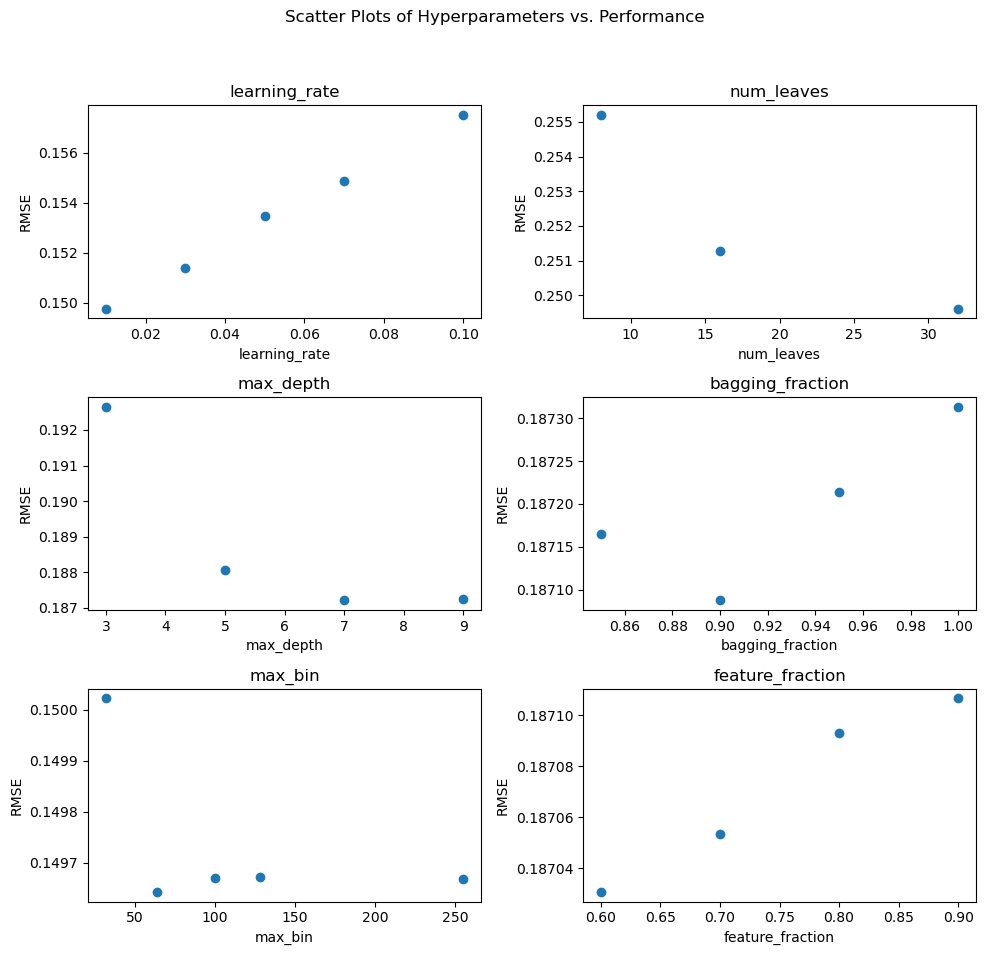

In [16]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
fig.suptitle('Scatter Plots of Hyperparameters vs. Performance')

param_names = list(param_grid.keys())

for i,(key, items) in enumerate(param_grid.items()):
    row, col = i // 2, i % 2
    axes[row, col].scatter(items, rmsle_params[key])
    axes[row, col].set_title(key)
    axes[row, col].set_xlabel(key)
    axes[row, col].set_ylabel('rmsle')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [17]:
%time model, predict = single_model(x_train, x_test, y_train, best_params=best_params)
output = pd.DataFrame({'id':id_test,'price_doc':predict})

Found `num_rounds` in params. Will use it instead of argument


CPU times: user 2min 57s, sys: 8.82 s, total: 3min 6s
Wall time: 36.5 s


In [18]:
output.to_csv('./csvs/submissions/model_1_output_lgb.csv',index=False)
print("Done")

Done


In [19]:
valid_x = x_test.drop(['timestamp','id'],axis=1)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(valid_x)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
All-NaN slice encountered


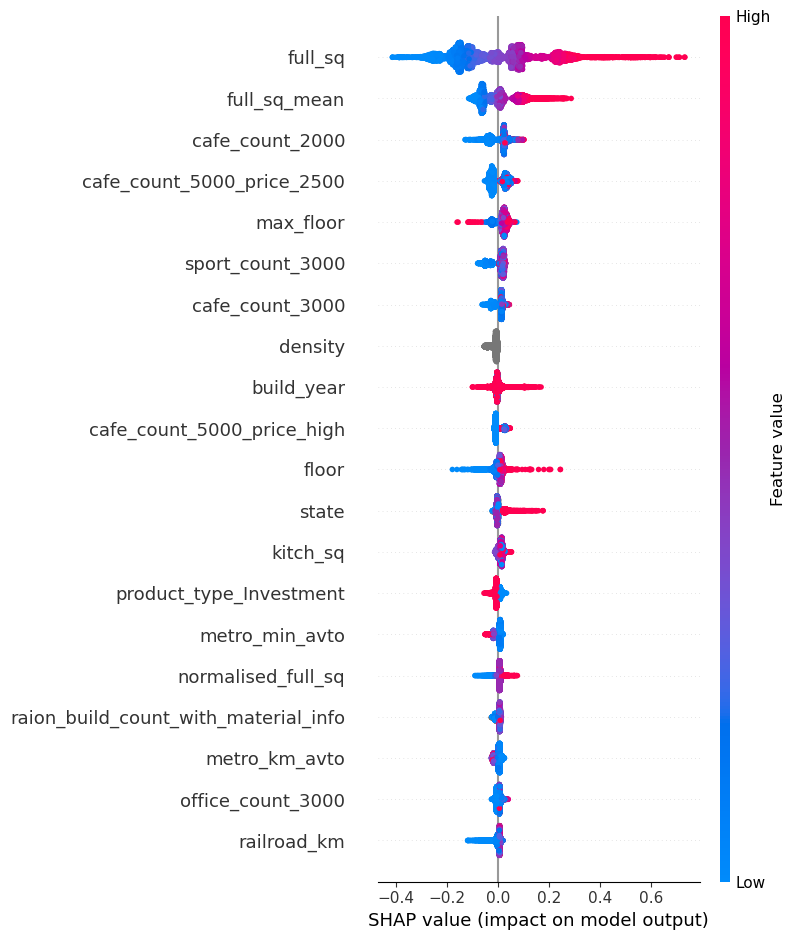

In [20]:
shap.summary_plot(shap_values, valid_x)

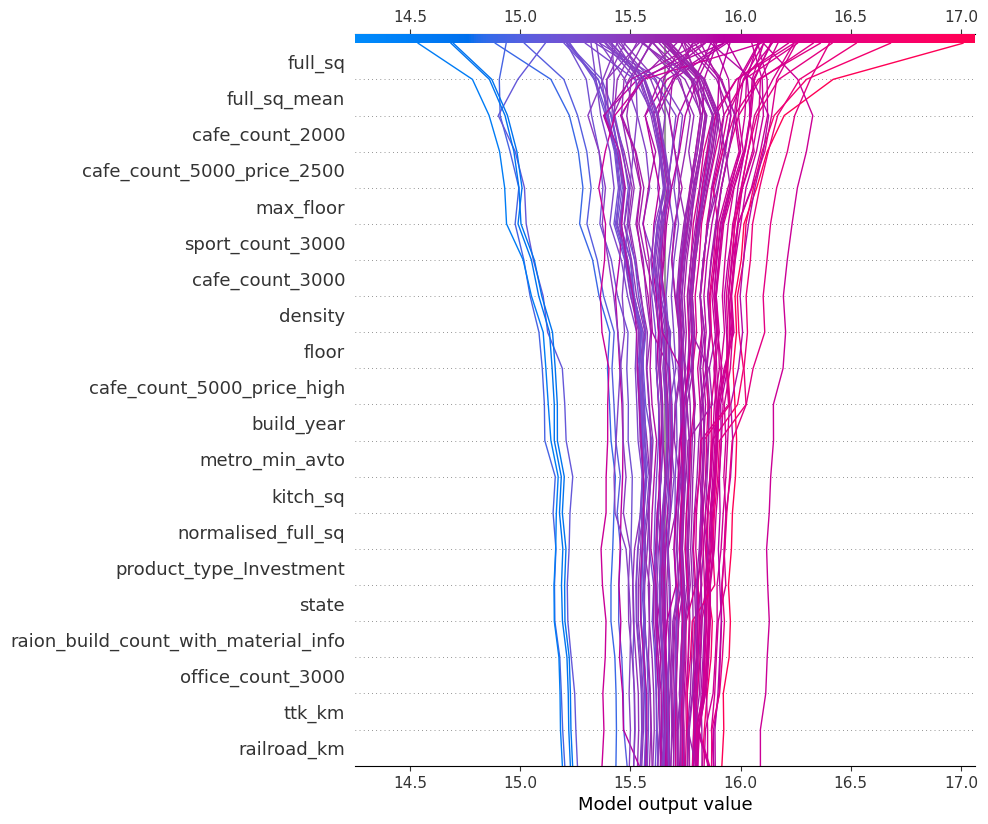

In [21]:
shap.decision_plot(explainer.expected_value, shap_values[:100], valid_x.columns)

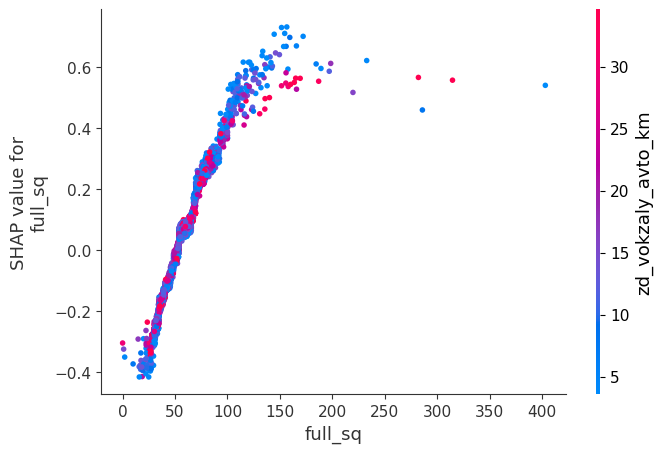

In [22]:
shap.dependence_plot("full_sq", shap_values, valid_x)